<a href="https://colab.research.google.com/github/bugraonsoz/DiabetesDataset/blob/main/EDA_for_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We have a dataset about properties and values about Diabetes Patitent. We will introduce with Python language and we analyze the data.

*We import libraries.*

In [21]:
import random
random.seed(2024)

import missingno as msno
import numpy as np
from scipy.stats import shapiro
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import load_diabetes, load_iris
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


# We load the diabetes data set.

In [22]:
# Load the data from `sklearn` as two pandas.DataFrame
diabetes_X, diabetes_y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

# Concatenate the two pandas.DataFrames into one
diabetes = pd.concat([diabetes_X, pd.Series(diabetes_y)], axis=1).rename({0: 'target'},axis=1)

# Load the data set from `sklearn` using another method in order to print
# the data set description of the data
diabetes_default = load_diabetes()

# Print the data set description:
print(diabetes_default['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [23]:
diabetes.size

4862

#*We see the information about columns.*

# We look randomly selected rows in dataset and we ascending the index.

In [24]:
diabetes.sample(5).sort_index()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
80,68.0,1.0,27.5,107.0,241.0,149.6,64.0,4.0,4.9200,90.0,143.0
113,54.0,2.0,27.7,113.0,200.0,128.4,37.0,5.0,5.1533,113.0,297.0
142,60.0,2.0,27.5,106.0,229.0,143.8,51.0,4.0,5.1417,91.0,235.0
281,23.0,2.0,18.0,78.0,171.0,96.0,48.0,4.0,4.9053,92.0,94.0
340,44.0,1.0,25.1,133.0,182.0,113.0,55.0,3.0,4.2485,84.0,216.0


#We saw the results. There may be missing values. So we have to check.

In [25]:
rows_isna=diabetes.isna().max(axis=0).max()
columns_isna=diabetes.isna().max(axis=1).max()
print(f"Rows with missing values: {rows_isna}")
print(f"Columns with missing values: {columns_isna}")

Rows with missing values: False
Columns with missing values: False


# *False means there isn't any missing values.*

# But in the real life, we could see the missing values. So let's create some NaN values.

In [26]:
# Set the random seed for reproducibility
random.seed(2024)

# Select 3 columns at random
missing_cols = random.sample(range(len(diabetes.columns) - 1), 3)

# Select 10% of the rows at random
missing_rows = random.sample(diabetes.index.tolist(), int(np.round(len(diabetes.index.tolist())/10)))

# Set the 3 selected columns to missing values for the 10% of selected rows
diabetes.iloc[missing_rows, missing_cols] = np.nan
# Print the selected columns which has NaN value.
print(sorted(diabetes.columns[missing_cols]))

['bmi', 's1', 's4']


# Let's check again.

In [27]:
rows_isna=diabetes.isna().max(axis=0).max()
columns_isna=diabetes.isna().max(axis=1).max()
print(f"Rows with missing values: {rows_isna}")
print(f"Columns with missing values: {columns_isna}")

Rows with missing values: True
Columns with missing values: True


# Let's convert some column types. Let's take 'sex'. We will convert the object to numeric type. Female equals 0, Male equals 1.

In [28]:
diabetes['sex'] = np.random.choice(['male', 'female'], size=len(diabetes))  # sex values 'male' and 'female'
# Converting 'sex' column to 0 and 1
diabetes['sex'] = diabetes['sex'].replace({'male': 1, 'female': 0})
# Print which column's value is 0 or 1 from random indexes.
print(diabetes[['sex']].sample(10))

     sex
362    1
333    0
302    1
97     1
206    0
227    0
201    1
378    1
344    1
224    1


# We create a train-test split. So we can see the values which is closer to minimum or maximum value.

In [29]:
# Make a train-test split so we can see the normalized values.
X_train, X_test, y_train, y_test = train_test_split(diabetes.iloc[:, :-1], diabetes.iloc[:, [-1]], test_size=0.33, random_state=2024)
diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


# We have missing values ​​and if we analyze this way, our analysis will be poor analysis. We can take mean or median of other values and fill with them. Or, we drop that rows.

# *The simplest strategy for dealing with rows that contain missing values is to drop them from the data set. To evaluate the performance of this model, you also calculate the root mean squared error (RMSE) of the prediction from the true value for the test set:*

In [30]:
# linear regression dropping NANs

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train.loc[nonnan_train_indices], y_train.loc[nonnan_train_indices])
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

57.14929557559398

# We end up with an RMSE of around *57.1233*. The RMSE value shows the average amount of error between the values ​​predicted by the model and the actual values. A value such as *57.1233* indicates that the predictions deviate from the actual values ​​by *57.1233* units, on average.
***In this case, if the scale of the target variable is small (for example, values ​​between 0-100), this error can be considered a large error. However, if the target variable has a large scale (for example, values ​​from 0 to 1000 or larger), this error may be more acceptable.***




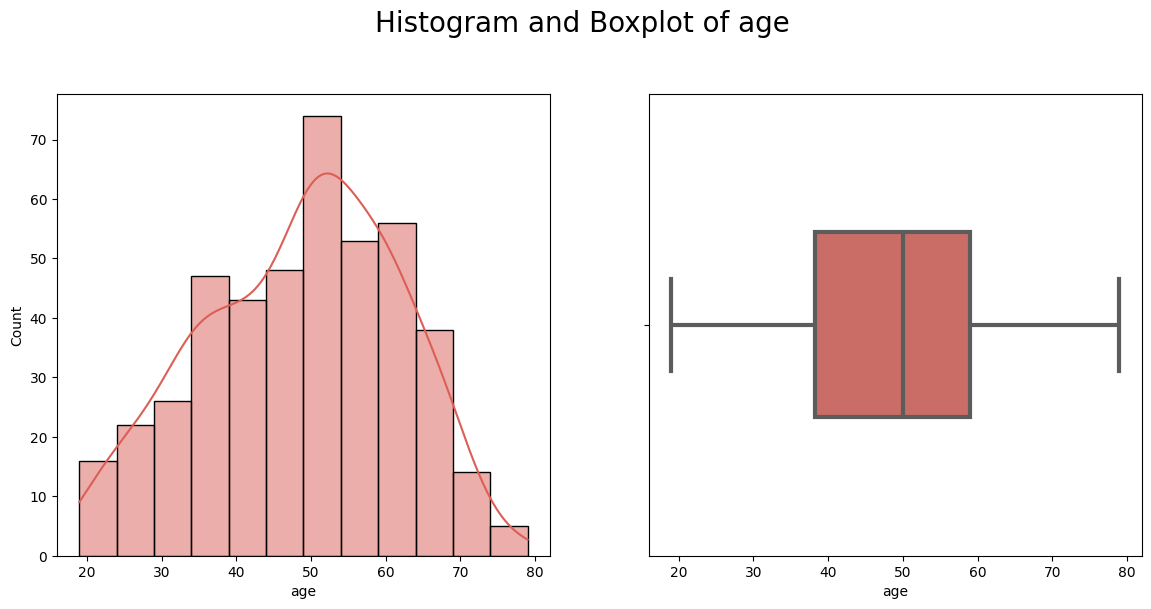

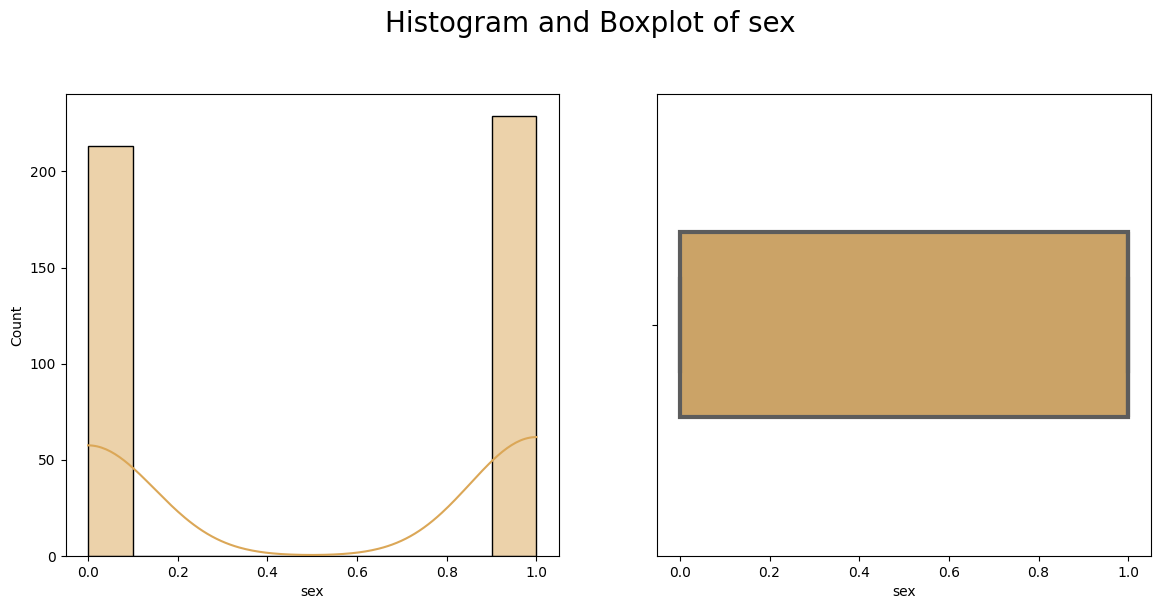

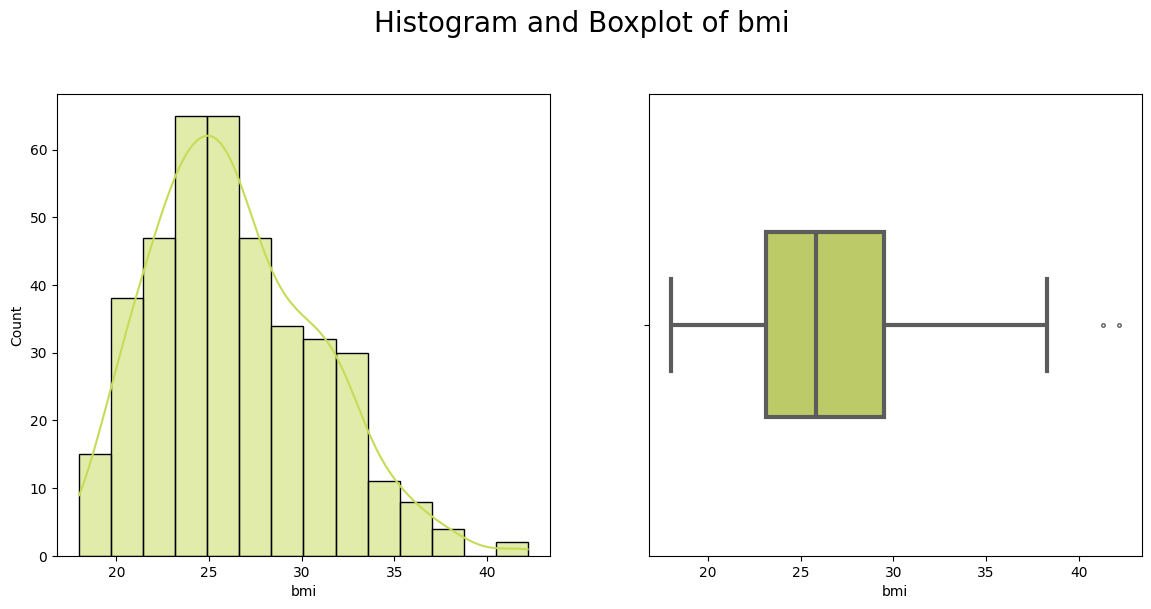

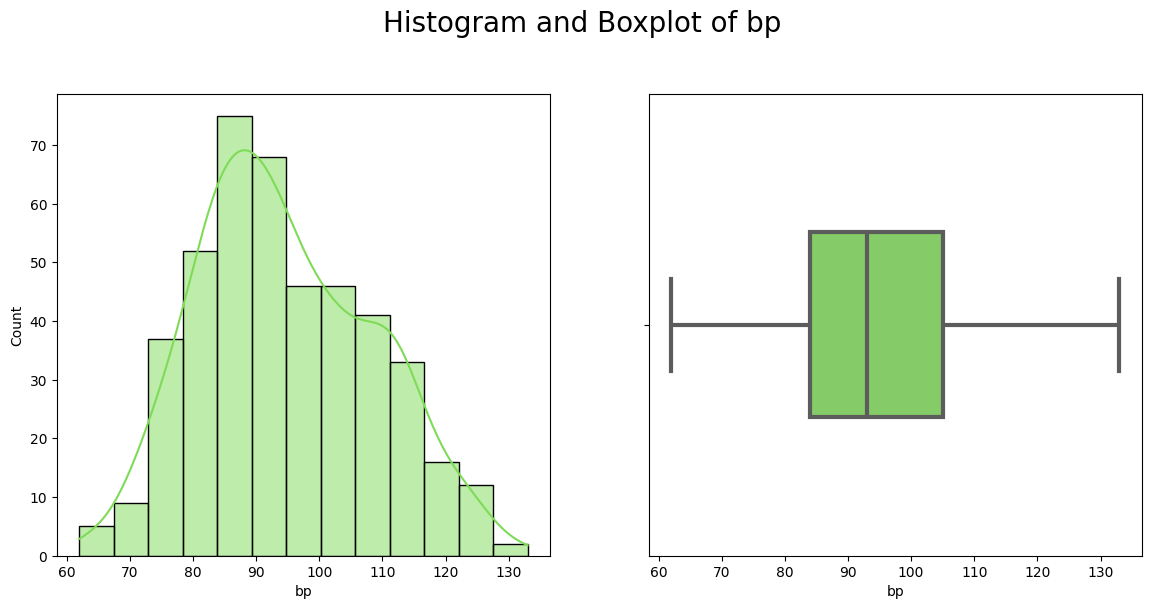

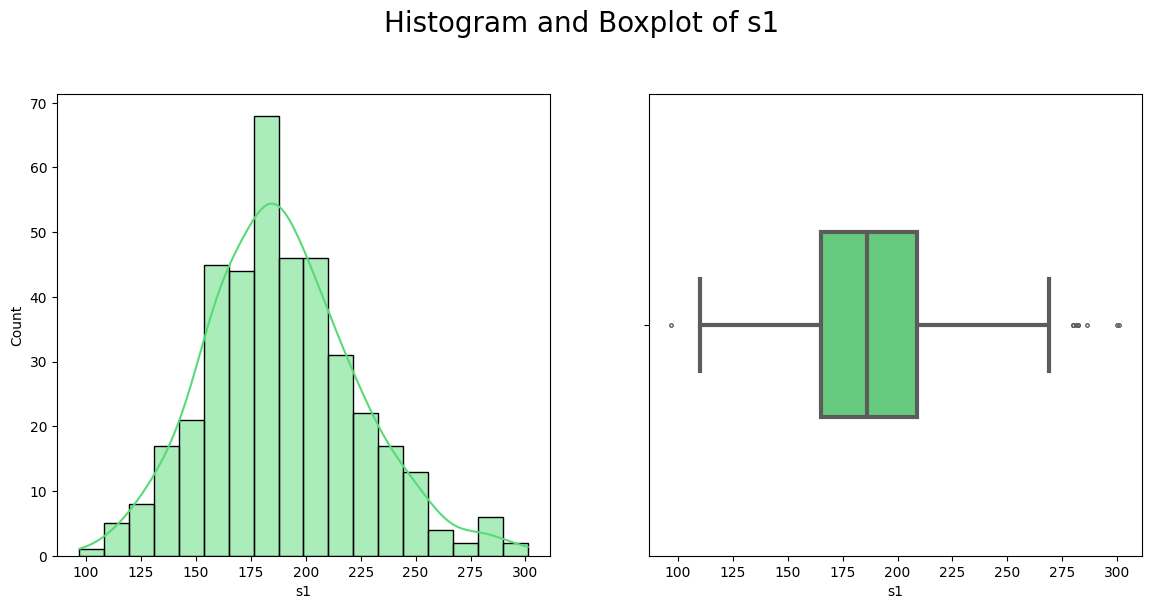

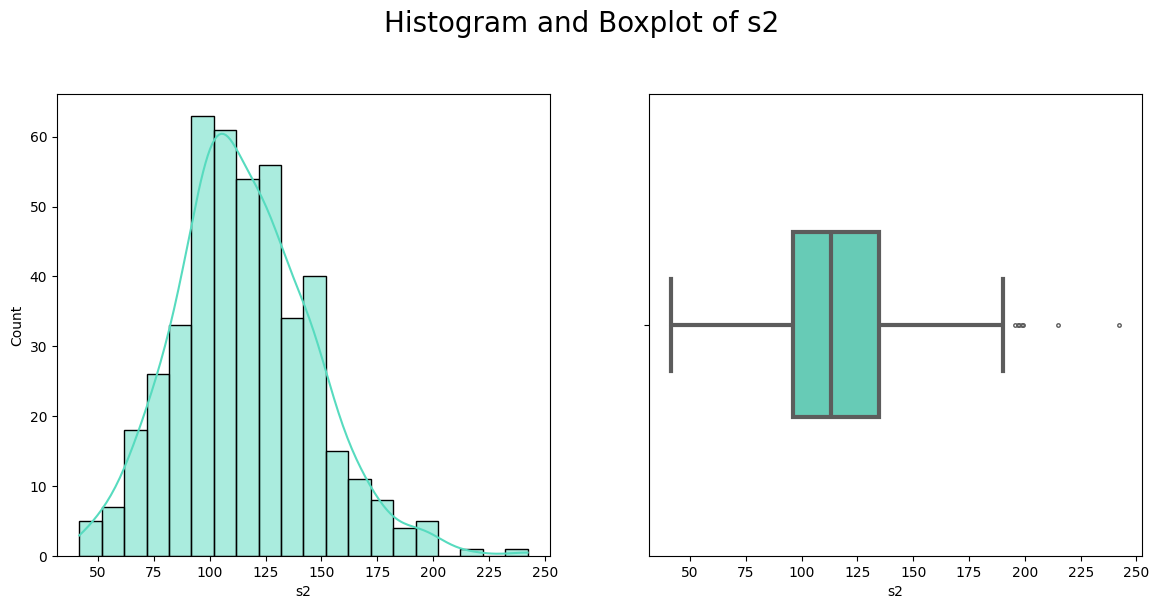

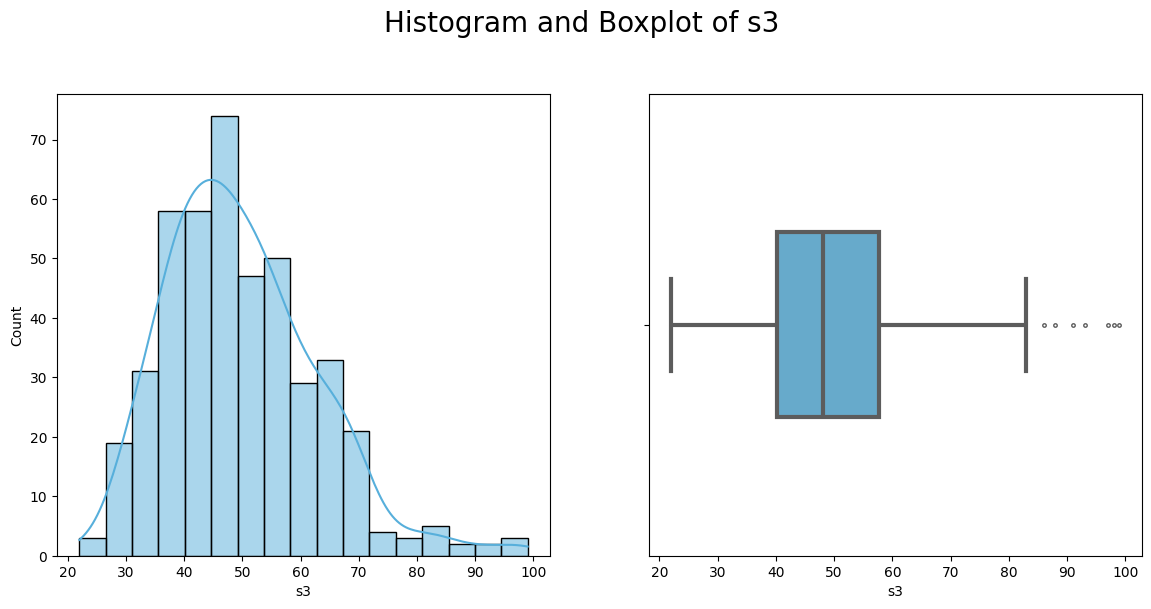

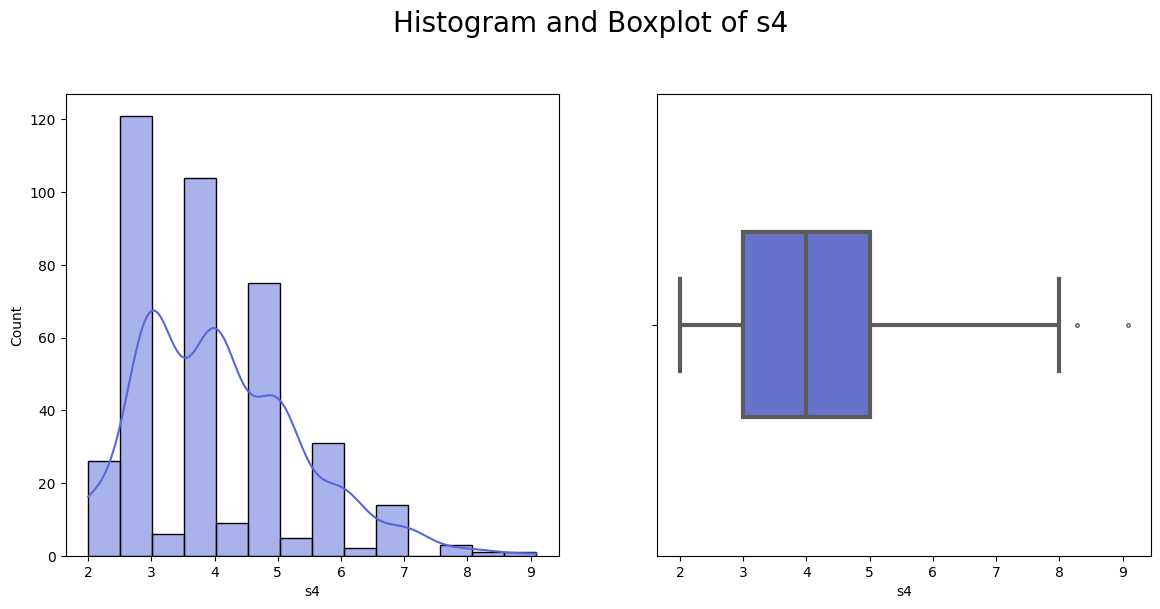

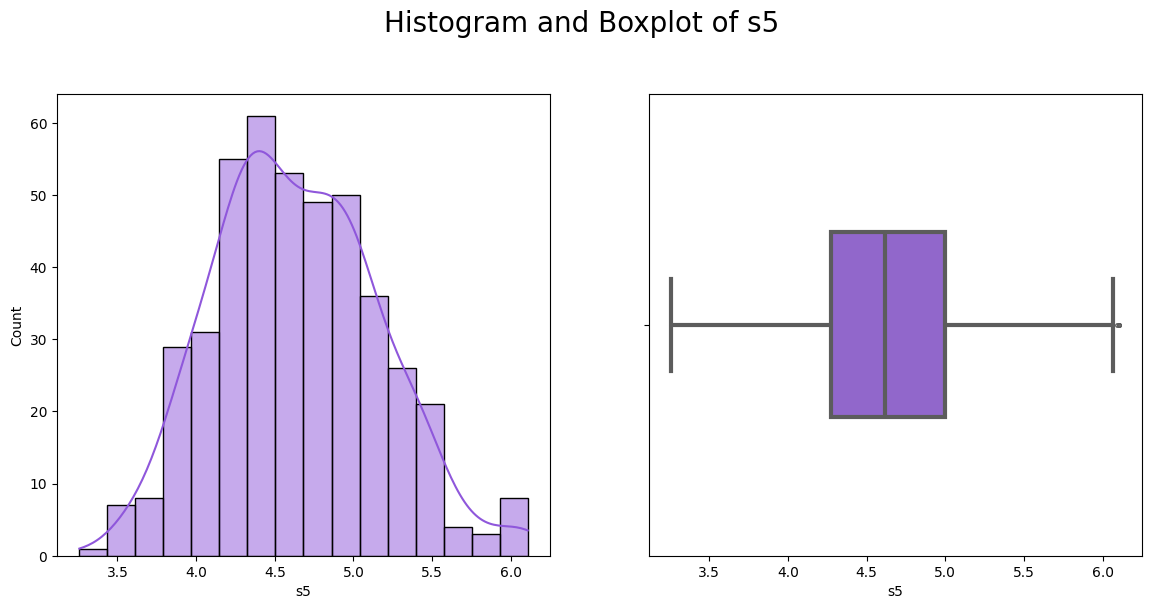

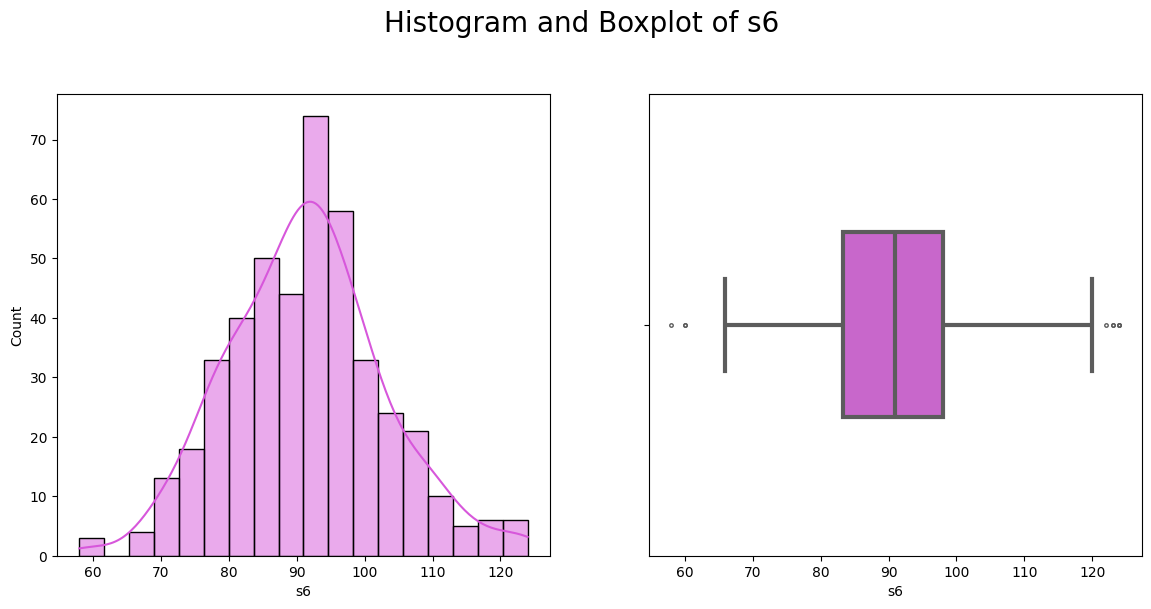

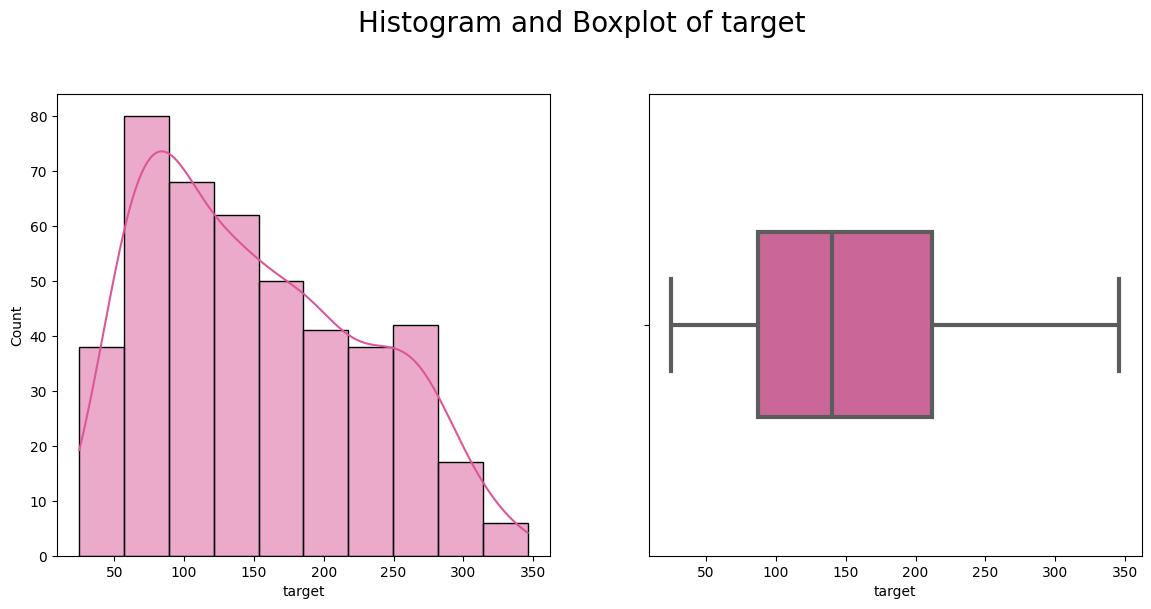

In [31]:
for idx, col in enumerate([i for i in diabetes.columns if i != 1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len([i for i in diabetes.columns if i != 1]))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len([i for i in diabetes.columns if i != 1]))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

# *`We can see on the histogram and boxplot graphics.The most common age is around 50's. There are more female than male. The most common body mass index is around 25's. And it goes on. `*

---



# *We can also see the relationship between the columns.*

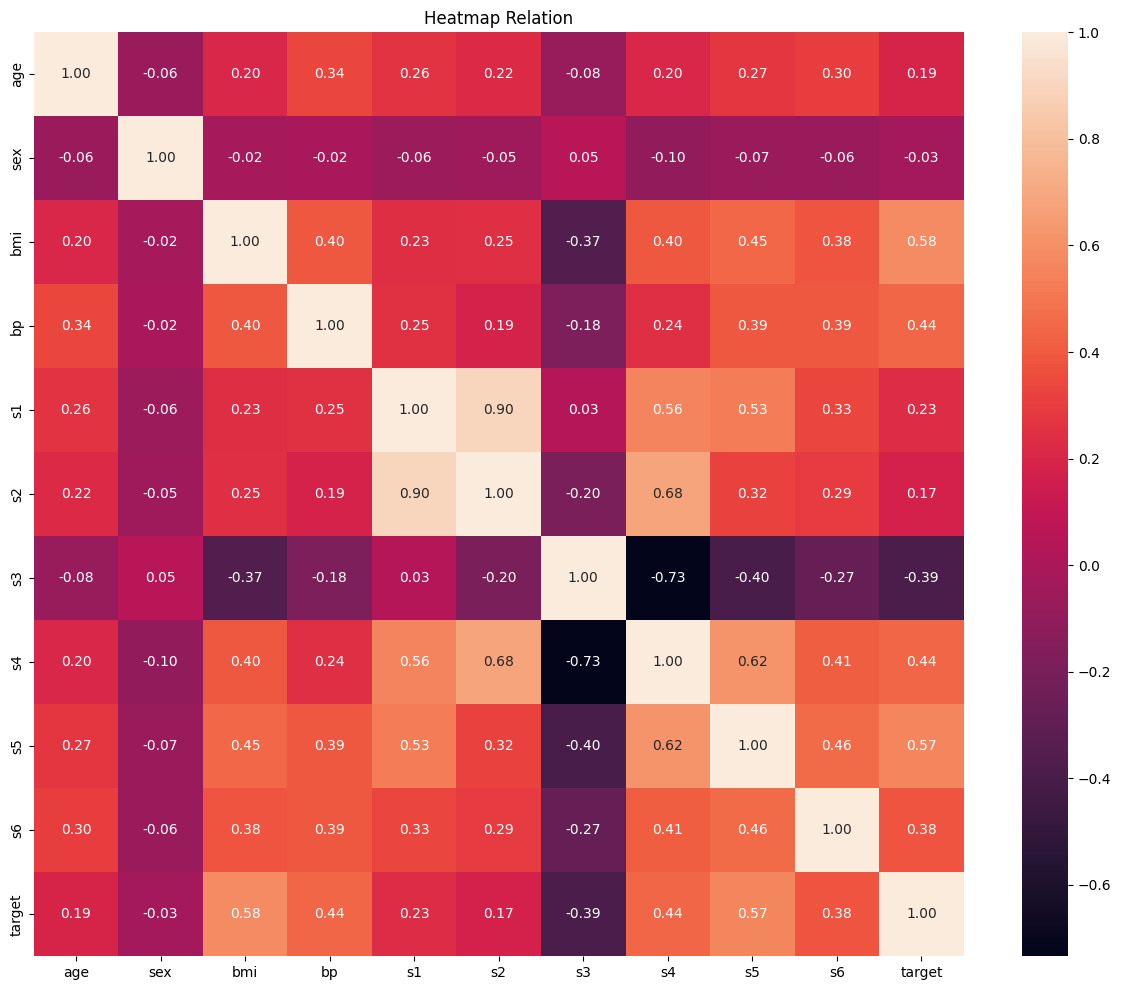

In [32]:
plt.figure(figsize=(15, 12))

plt.title("Heatmap Relation")

sns.heatmap(diabetes.corr(), annot=True, fmt='.2f');

#`***The most relation to target are 'body mass index(bmi)'.***`

# **The result is body mass index, total cholesterol / HDL and possibly log of serum triglycerides level. So when they are increase, the target get increase and the patient has a diabetes.**